In [1]:
import keras
import os
import cv2
import numpy as np  
import pandas as pd 
import seaborn as sns     
import tensorflow as tf 
from tabulate import tabulate
from termcolor import colored  
import matplotlib.pyplot as plt  
from IPython.display import display
from keras.models import Sequential
from keras import models, layers, optimizers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Reshape
sns.set_style('whitegrid')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

2024-08-18 04:33:24.720073: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 04:33:24.720187: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 04:33:24.823998: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dir1 = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'
# Detect classes
detection = [class_name for class_name in os.listdir(dir1) if class_name]
detection.remove('Rice_Citation_Request.txt')
print(detection)

['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']


In [3]:
image_data = []  # Initialize an empty list for storing image paths and labels

# Iterate through each class in the detection
for class_name in detection:
    class_path = os.path.join(dir1, class_name)  # Create the path for the class
    files = os.listdir(class_path)  # List all files in the class folder
    
    # Loop through all files and add their paths and class labels to the image_data list
    for file in files:
        file_path = os.path.join(class_path, file)  # Create the full file path
        image_data.append((file_path, class_name))  # Append tuple to the list

# Convert the list to a pandas DataFrame
df = pd.DataFrame(image_data, columns=['path', 'label'])

# Shuffle the DataFrame rows for randomness
df = df.sample(frac=1).reset_index(drop=True)


In [4]:
df

,path,label
0,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Arborio
1,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Jasmine
2,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
3,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Basmati
4,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Arborio
...,...,...
74995,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
74996,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Ipsala
74997,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Jasmine
74998,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Jasmine


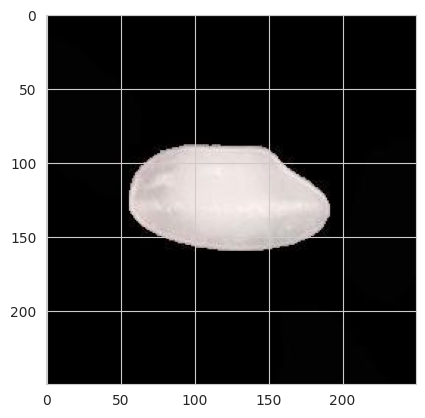

In [6]:
img = cv2.imread(df.iloc[0]['path'])
plt.imshow(img)

In [7]:
training_data = df[:60000]
validation_data = df[60000:67500]
test_data = df[67500:]

# Set image dimensions and batch size
IMAGE_SIZE = (250, 250)
BATCH_SIZE = 16

# Initialize the ImageDataGenerator for image normalization
data_gen = ImageDataGenerator(rescale=1.0/255)

# Function to create data generators
def create_data_generator(dataframe, is_training=False):
    return data_gen.flow_from_dataframe(
        dataframe,
        x_col='path',
        y_col='label',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=is_training)

# Create generators for training, validation, and test datasets
train_generator = create_data_generator(training_data, is_training=True)
valid_generator = create_data_generator(validation_data, is_training=False)
test_generator = create_data_generator(test_data, is_training=False)

Found 60000 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.


In [8]:
images, labels = next(train_generator)

In [9]:
images.shape


(16, 250, 250, 3)

In [10]:
model = Sequential()

# First Convolutional Block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Block
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Block
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth Convolutional Block
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the layers
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))

# Output Layer (assuming a multi-class classification with 'n_classes' classes)
n_classes = len(train_generator.class_indices)  # Ensure this is correctly set
model.add(Dense(n_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 248, 248, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 124, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 122, 122, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 59, 59, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 27, 27, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    22,151,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,672,709 (86.49 MB)

 Trainable params: 22,672,709 (86.49 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(
    train_generator,            # Training data generator
    epochs=10,                  # Number of epochs
    validation_data=valid_generator,  # Validation data generator
    batch_size=BATCH_SIZE  # Number of steps for validation
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-08-18 04:37:01.335986: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 61505: 6.49914, expected 5.67568
2024-08-18 04:37:01.336048: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 61510: 6.99517, expected 6.17172
2024-08-18 04:37:01.336058: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 61511: 6.21643, expected 5.39297
2024-08-18 04:37:01.336066: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 61513: 6.397, expected 5.57355
2024-08-18 04:37:01.336074: E external/local_xla/xla/service/gpu/buffer_co

   3/3750 ━━━━━━━━━━━━━━━━━━━━ 3:26 55ms/step - accuracy: 0.3993 - loss: 1.8675   

I0000 00:00:1723955829.028705     134 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723955829.050829     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3749/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9274 - loss: 0.2113

W0000 00:00:1723956122.147567     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-08-18 04:42:37.666311: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.63896, expected 5.71781
2024-08-18 04:42:37.666371: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 8.17852, expected 7.25737
2024-08-18 04:42:37.666388: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 7.94165, expected 7.0205
2024-08-18 04:42:37.666405: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 7.27562, expected 6.35447
2024-08-18 04:42:37.666417: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.68515, expected 5.76399
2024-08-18 04:42:37.666428: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 7.26117, expected 6.34001
2024-08-18 04:42:37.666439: E external/local_xla/xla/service/gpu/b

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 342s 88ms/step - accuracy: 0.9274 - loss: 0.2113 - val_accuracy: 0.9631 - val_loss: 0.1445
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 119s 32ms/step - accuracy: 0.9660 - loss: 0.1075 - val_accuracy: 0.9705 - val_loss: 0.1012
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 122s 32ms/step - accuracy: 0.9691 - loss: 0.0954 - val_accuracy: 0.9660 - val_loss: 0.1194
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 116s 31ms/step - accuracy: 0.9704 - loss: 0.0899 - val_accuracy: 0.9727 - val_loss: 0.0821
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 120s 32ms/step - accuracy: 0.9742 - loss: 0.0869 - val_accuracy: 0.9740 - val_loss: 0.0889
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 118s 31ms/step - accuracy: 0.9739 - loss: 0.0857 - val_accuracy: 0.9705 - val_loss: 0.1125
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 116s 31ms/step - accuracy: 0.9759 - loss: 0.0810 - val_accuracy: 0.9768 - val_loss: 0.0738
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 118s 31ms/step - accuracy: 0.9780 - lo

In [12]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 91ms/step - accuracy: 0.9748 - loss: 0.1133
Test Accuracy: 97.37%
